In [1]:
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import math
import ast
from scipy.stats import median_abs_deviation, hypergeom, mannwhitneyu
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
# Saving plots with editable text
plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts (editable text)

In [2]:
import dictys
from utils_custom import *
from pseudotime_curves import *
from episode_plots import *
from episodic_dynamics import *
from config import *

In [3]:
config = Config()

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/dynamic.h5')

# Fig 4 - Cell state distributions per fate

#### Get cell state labels for each window

In [5]:
cell_labels = pd.read_csv(config.CELL_LABELS, header=0)
display(cell_labels.index)

RangeIndex(start=0, stop=28494, step=1)

In [6]:
cell_assignment_matrix = dictys_dynamic_object.prop["sc"]["w"]
state_labels_in_window = {}
for window_idx in range(cell_assignment_matrix.shape[0]):
    indices_of_cells_present_in_window = np.where(
        cell_assignment_matrix[window_idx] == 1
        )[0] #these indices start from 0
    state_labels_in_window[window_idx] = [
        cell_labels.iloc[int(idx)]['Cluster'] for idx in indices_of_cells_present_in_window
        ]

In [7]:
state_count_per_window = window_labels_to_count_df(state_labels_in_window)
state_count_per_window = state_count_per_window.drop(index=['ActB-1', 'earlyActB'])

#### Always use pseudotime to bin windows instead of window indices - as pseudotime is the temporal spread/distribution and not the indices

In [8]:
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

In [9]:
# Define distinct colors for better visibility
colors_cell_count = {
    'ActB-1': '#87CEFA',     # lightskyblue
    'ActB-2': '#1E90FF',     # dodgerblue
    'ActB-3': '#00008B',     # darkblue
    'ActB-4': '#9370DB',     # mediumorchid
    'GC-1': '#7BDE7B',       # custom light green
    'GC-2': '#008000',       # green
    'PB-2': '#BB3636',       # custom red
    'earlyActB': '#008080',   # teal
    'earlyPB': '#F08080'   # lightcoral
}

In [14]:
pseudotime_values_of_windows = AlignTimeScales(dictys_dynamic_object, trajectory_range=[0, 2]).pseudotime_of_windows()

Time points per bin: [15, 17, 3, 3, 4, 3, 5, 1]
Total cells per bin: [np.float64(999.8), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0)]


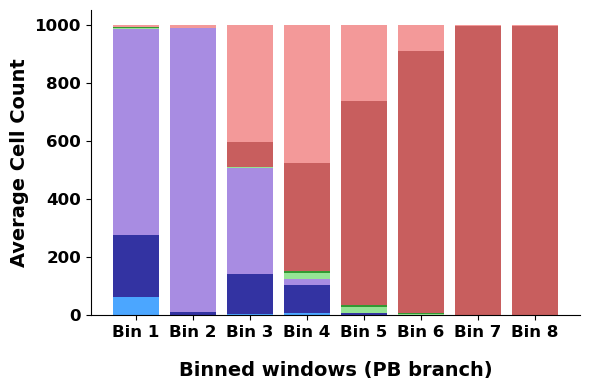

In [15]:
# Create a new dataframe with only the columns in PB_fate_window_indices
df_plot = state_count_per_window[PB_post_bifurcation_window_indices]
# Create time bins
n_bins = 8  # Adjust this number as needed
x = [pseudotime_values_of_windows[i] for i in PB_post_bifurcation_window_indices]
x_min, x_max = min(x), max(x)

# Create bin edges
bin_edges = np.linspace(x_min, x_max, n_bins + 1)
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(n_bins)]

# Initialize binned data and count time points per bin
binned_data = {state: [0] * n_bins for state in df_plot.index}
bin_counts = [0] * n_bins  # Track how many time points are in each bin

# Aggregate data into bins
for i, time_point in enumerate(x):
    # Find which bin this time point belongs to
    bin_idx = np.digitize(time_point, bin_edges) - 1
    bin_idx = max(0, min(bin_idx, n_bins - 1))  # Ensure within bounds
    
    # Add counts for each cell state to the appropriate bin
    for state in df_plot.index:
        binned_data[state][bin_idx] += df_plot.loc[state].values[i]
    
    bin_counts[bin_idx] += 1

# Average the counts within each bin (so each bin represents average composition)
for state in df_plot.index:
    for bin_idx in range(n_bins):
        if bin_counts[bin_idx] > 0:
            binned_data[state][bin_idx] = binned_data[state][bin_idx] / bin_counts[bin_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.style.use('default')
plt.grid(False)

# Initialize bottom array for stacking
bottom = [0] * n_bins

# Plot each cell state as a layer in the stacked bar
for state in df_plot.index:
    y = binned_data[state]
    plt.bar(range(n_bins), y,
            label=state,
            color=colors_cell_count[state],
            bottom=bottom,
            alpha=0.8)
    
    # Update bottom for next stack layer
    bottom = [bottom[i] + y[i] for i in range(n_bins)]

plt.xlabel('Binned windows (PB branch)', fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel('Average Cell Count', fontsize=14, fontweight='bold')
plt.xticks(range(n_bins), [f"Bin {i+1}" for i in range(n_bins)], fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save figure
#plt.savefig(os.path.join(output_folder, 'fig4_state_count_PB_bins.pdf'), dpi=1200)
#plt.show()
# Print bin info for verification
print("Time points per bin:", bin_counts)
print("Total cells per bin:", [sum(binned_data[state][i] for state in df_plot.index) for i in range(n_bins)])

# Pseudotime curves of TF expression and activity

In [41]:
exp_curves_dy, exp_curves_dx = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,3),
    num_points=100,
    dist=0.0005,
    sparsity=0.01).get_smoothed_curves(mode="expression")

In [42]:
reg_curves_dy, reg_curves_dx = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,3),
    num_points=100,
    dist=0.0005,
    sparsity=0.01).get_smoothed_curves(mode="regulation")

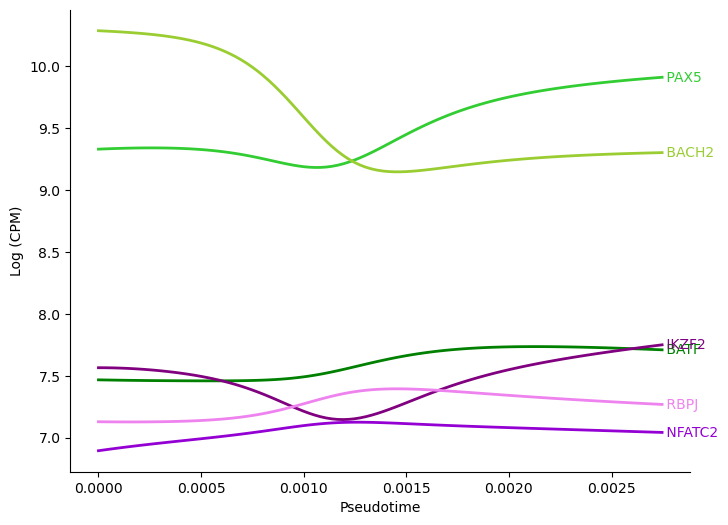

In [55]:
# Plot expression trajectories
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
#genes_of_interest_pb = ['CREB3L2','RUNX2']
#genes_of_interest_pb = ['IRF4','PRDM1']
#genes_of_interest_pb = ['BACH2','XBP1']
#genes_of_interest_gc = ['IRF4','NFKB1','PRDM1']
#genes_of_interest_gc = ['PAX5','BATF','CREB3L2']
genes_of_interest_gc = ['PAX5','BATF','BACH2','IKZF2','RBPJ','NFATC2']
#colors_pb = ['blueviolet','slateblue']
#colors_pb = ['lightcoral','firebrick']
#colors_pb = ['darkorange','sienna']
#colors_gc = ['blue','dodgerblue','midnightblue']
#colors_gc = ['limegreen','green','olivedrab']
colors_gc = ['limegreen','green','yellowgreen','purple','violet','darkviolet']

for gene, color in zip(genes_of_interest_gc, colors_gc):
    if gene in exp_curves_dy.index:
        line = plt.plot(exp_curves_dx, exp_curves_dy.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(exp_curves_dx.iloc[-1], exp_curves_dy.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log (CPM)')
#save the figure
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'tfs_enriched_in_ko_programs_exp.pdf'), dpi=300)
plt.show()

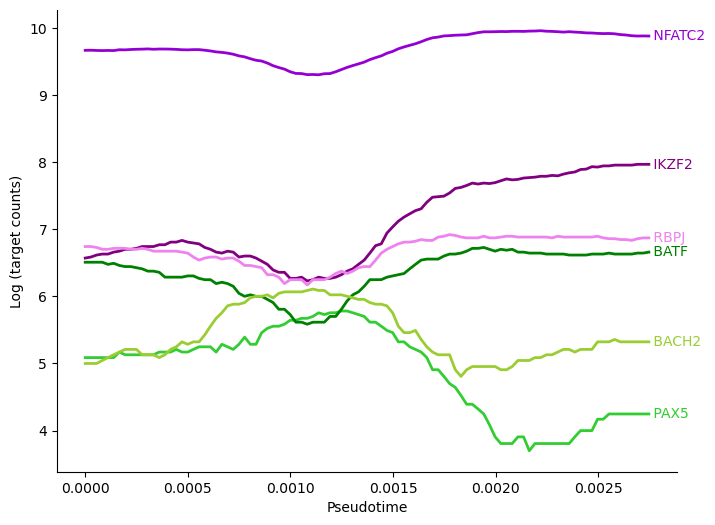

In [56]:
# Plot regulation trajectories
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
#genes_of_interest_pb = ['CREB3L2','RUNX2']
#genes_of_interest_pb = ['IRF4','PRDM1']
#genes_of_interest_pb = ['BACH2','XBP1']
#genes_of_interest_gc = ['IRF4','NFKB1','PRDM1']
#genes_of_interest_gc = ['PAX5','BATF','CREB3L2']
genes_of_interest_gc = ['PAX5','BATF','BACH2','IKZF2','RBPJ','NFATC2']
#colors_pb = ['blueviolet','slateblue']
#colors_pb = ['lightcoral','firebrick']
#colors_pb = ['darkorange','sienna']
#colors_gc = ['blue','dodgerblue','midnightblue']
#colors_gc = ['limegreen','green','olivedrab']
colors_gc = ['limegreen','green','yellowgreen','purple','violet','darkviolet']

for gene, color in zip(genes_of_interest_gc, colors_gc):
    if gene in reg_curves_dy.index:
        line = plt.plot(reg_curves_dx, reg_curves_dy.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(reg_curves_dx.iloc[-1], reg_curves_dy.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log (target counts)')
#save the figure
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'tfs_enriched_in_ko_programs_reg.pdf'), dpi=300)
plt.show()

# Enriched links

In [74]:
PB_links_plotting = [('RUNX2','PRDM1'),('CREB3L2','RUNX2'),('IRF4','CDK6'),('CREB3L2','FNDC3A'),('CREB3L2','MZB1'),('CREB3L2','TXNDC5'),('TCF12','SEL1L3'),('IRF4','PRDM1'),
                    ('PRDM1','IRF4'),('IRF4','ELL2'),('BACH2','XBP1'),('XBP1','PPIB'),('XBP1','TXNDC11'),('XBP1','HSP90B1'),('CREB3L2','FNDC3B'),('PRDM1','RUNX2')]

In [33]:

GC_links_plotting = [('ARID5B','PIKFYVE'),('ARID5B','PDE4D'),('IRF4','PAX5'),('NFKB1','PAX5'),('IRF4','AFF3'),('NFKB1','AFF3'),('BATF','PPIB'),('BACH2','MZB1'),('PAX5','GLCCI1'),
                     ('PAX5','PRDM1'),('CREB3L2','PAX5')]


#### Initialize pseudotime object

In [75]:
pseudotime_object = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,2),
    num_points=100,
    dist=0.0005,
    sparsity=0.01)

In [76]:
beta_curves, dtime = pseudotime_object.get_beta_curves(PB_links_plotting, varname='w_in')

In [77]:
display(beta_curves)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF      Target                                                                
IRF4    SEL1L3  -0.008434 -0.008043 -0.007606 -0.007128 -0.006618 -0.006080   
        IRF4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        PPIB    -0.004137 -0.004119 -0.004096 -0.004072 -0.004049 -0.004027   
        XBP1    -0.000549 -0.000467 -0.000391 -0.000320 -0.000253 -0.000190   
        HSP90B1  0.001340  0.001328  0.001278  0.001191  0.001070  0.000918   
...                   ...       ...       ...       ...       ...       ...   
CREB3L2 TXNDC5   0.034675  0.034870  0.034949  0.034913  0.034770  0.034528   
        CDK6     0.001841  0.001703  0.001582  0.001478  0.001390  0.001318   
        ELL2    -0.011655 -0.012004 -0.012355 -0.012705 -0.013052 -0.013395   
        MZB1     0.003484  0.004296  0.005204  0.006210  0.007318  0.008529   
        TXNDC11 -0.006582 -0.006573 -0.006559 -0.006542 -0.006522 -0.006500   

                   time_6    time_7    time_8    time_9  ...   time_90  \
TF      Target                                           ...             
IRF4    SEL1L3  -0.005522 -0.004952 -0.004375 -0.003798  ...  0.004468   
        IRF4     0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        PPIB    -0.004010 -0.004000 -0.003999 -0.004008  ...  0.000562   
        XBP1    -0.000129 -0.000070 -0.000014  0.000039  ...  0.011901   
        HSP90B1  0.000737  0.000531  0.000303  0.000055  ...  0.003145   
...                   ...       ...       ...       ...  ...       ...   
CREB3L2 TXNDC5   0.034196  0.033788  0.033315  0.032791  ...  0.016927   
        CDK6     0.001261  0.001217  0.001184  0.001163  ... -0.012044   
        ELL2    -0.013732 -0.014061 -0.014380 -0.014689  ... -0.003180   
        MZB1     0.009844  0.011264  0.012788  0.014417  ... -0.008599   
        TXNDC11 -0.006476 -0.006450 -0.006424 -0.006396  ... -0.007618   

                  time_91   time_92   time_93   time_94   time_95   time_96  \
TF      Target                                                                
IRF4    SEL1L3   0.003920  0.003353  0.002771  0.002177  0.001573  0.000962   
        IRF4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        PPIB     0.000180 -0.000182 -0.000524 -0.000846 -0.001148 -0.001430   
        XBP1     0.011652  0.011367  0.011047  0.010694  0.010311  0.009899   
        HSP90B1  0.002037  0.000905 -0.000248 -0.001417 -0.002597 -0.003785   
...                   ...       ...       ...       ...       ...       ...   
CREB3L2 TXNDC5   0.016817  0.016694  0.016555  0.016399  0.016224  0.016029   
        CDK6    -0.012025 -0.011965 -0.011866 -0.011733 -0.011568 -0.011374   
        ELL2    -0.003359 -0.003565 -0.003797 -0.004055 -0.004338 -0.004645   
        MZB1    -0.008556 -0.008507 -0.008450 -0.008386 -0.008312 -0.008230   
        TXNDC11 -0.007146 -0.006645 -0.006118 -0.005566 -0.004992 -0.004400   

                  time_97   time_98   time_99  
TF      Target                                 
IRF4    SEL1L3   0.000348 -0.000266 -0.000880  
        IRF4     0.000000  0.000000  0.000000  
        PPIB    -0.001693 -0.001937 -0.002163  
        XBP1     0.009460  0.008998  0.008513  
        HSP90B1 -0.004977 -0.006170 -0.007360  
...                   ...       ...       ...  
CREB3L2 TXNDC5   0.015814  0.015579  0.015324  
        CDK6    -0.011155 -0.010913 -0.010652  
        ELL2    -0.004976 -0.005328 -0.005701  
        MZB1    -0.008138 -0.008036 -0.007924  
        TXNDC11 -0.003791 -0.003169 -0.002537  

[98 rows x 100 columns]

In [78]:
# get the expression curves of the TFs in the specified links
tf_expression, _ = pseudotime_object.get_smoothed_curves(mode='tf_expression')
regulon_tf_expression = tf_expression.loc[beta_curves.index.get_level_values(0).unique()]

In [79]:
force_curves = pseudotime_object.calculate_force_curves(beta_curves, regulon_tf_expression)

In [80]:
display(force_curves)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF      Target                                                                
IRF4    SEL1L3  -0.304775 -0.298623 -0.291508 -0.283443 -0.274444 -0.264520   
        IRF4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        PPIB    -0.223689 -0.223304 -0.222812 -0.222263 -0.221706 -0.221192   
        XBP1    -0.093039 -0.086730 -0.080310 -0.073639 -0.066519 -0.058658   
        HSP90B1  0.137099  0.136592  0.134337  0.130308  0.124398  0.116380   
...                   ...       ...       ...       ...       ...       ...   
CREB3L2 TXNDC5   0.505346  0.507504  0.508905  0.509571  0.509536  0.508844   
        CDK6     0.141226  0.136770  0.132698  0.129061  0.125895  0.123225   
        ELL2    -0.314736 -0.319379 -0.323976 -0.328505 -0.332946 -0.337283   
        MZB1     0.186280  0.204402  0.222545  0.240730  0.258962  0.277235   
        TXNDC11 -0.245570 -0.245868 -0.246087 -0.246239 -0.246334 -0.246380   

                   time_6    time_7    time_8    time_9  ...   time_90  \
TF      Target                                           ...             
IRF4    SEL1L3  -0.253677 -0.241912 -0.229201 -0.215498  ...  0.253104   
        IRF4     0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        PPIB    -0.220773 -0.220501 -0.220426 -0.220597  ...  0.102869   
        XBP1    -0.049547 -0.038040 -0.018949  0.029345  ...  0.387352   
        HSP90B1  0.105809  0.091761  0.071881  0.034313  ...  0.217325   
...                   ...       ...       ...       ...  ...       ...   
CREB3L2 TXNDC5   0.507547  0.505710  0.503405  0.500710  ...  0.423609   
        CDK6     0.121058  0.119385  0.118183  0.117418  ... -0.365402   
        ELL2    -0.341498 -0.345577 -0.349508 -0.353280  ... -0.204937   
        MZB1     0.295534  0.313844  0.332146  0.350423  ... -0.315658   
        TXNDC11 -0.246387 -0.246359 -0.246299 -0.246208  ... -0.299478   

                  time_91   time_92   time_93   time_94   time_95   time_96  \
TF      Target                                                                
IRF4    SEL1L3   0.239120  0.223437  0.205668  0.185177  0.160787  0.129886   
        IRF4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        PPIB     0.062800 -0.062975 -0.099747 -0.122819 -0.140225 -0.154263   
        XBP1     0.383788  0.379656  0.374954  0.369682  0.363838  0.357419   
        HSP90B1  0.179961  0.126486 -0.072101 -0.153658 -0.199907 -0.235422   
...                   ...       ...       ...       ...       ...       ...   
CREB3L2 TXNDC5   0.422638  0.421509  0.420194  0.418672  0.416923  0.414935   
        CDK6    -0.365345 -0.364738 -0.363617 -0.362015 -0.359966 -0.357501   
        ELL2    -0.209968 -0.215570 -0.221673 -0.228209 -0.235111 -0.242316   
        MZB1    -0.315146 -0.314521 -0.313769 -0.312877 -0.311834 -0.310630   
        TXNDC11 -0.291438 -0.282532 -0.272696 -0.261851 -0.249889 -0.236658   

                  time_97   time_98   time_99  
TF      Target                                 
IRF4    SEL1L3   0.083533 -0.074353 -0.124876  
        IRF4     0.000000  0.000000  0.000000  
        PPIB    -0.165982 -0.175968 -0.184592  
        XBP1     0.350422  0.342841  0.334666  
        HSP90B1 -0.265127 -0.291029 -0.314171  
...                   ...       ...       ...  
CREB3L2 TXNDC5   0.412696  0.410198  0.407436  
        CDK6    -0.354650 -0.351444 -0.347913  
        ELL2    -0.249766 -0.257408 -0.265193  
        MZB1    -0.309256 -0.307703 -0.305966  
        TXNDC11 -0.221944 -0.205424 -0.186586  

[98 rows x 100 columns]

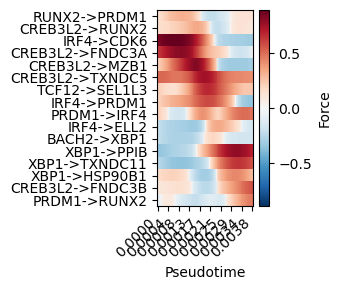

In [81]:
row_scaling = {
    ('NFKB1', 'AFF3'): 0.4  # Scale this GC link to x% of its original values
}

df_plot = force_curves.loc[PB_links_plotting]

force_df_for_cluster, reg_labels, dtime, fig = plot_force_heatmap_with_clustering(
    force_df=df_plot,
    dtime=dtime,
    regulations=PB_links_plotting,
    cmap='RdBu_r',
    vmax=None,
    figsize= (3.5, 3),
    plot_figure=True,
    perform_clustering=False,
    row_scaling=None
)
plt.yticks(fontsize=10)
plt.tight_layout()
# plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'enriched_links_GC.pdf'), 
#             bbox_inches='tight', 
#             dpi=300,
#             format='pdf')
plt.show()

# Fig 5/6 - Episodic enrichment plots
### Direct effect enrichment 

In [27]:
df_ep1 = pd.read_csv(config.ETS1_ALL['ep1'])
df_ep2 = pd.read_csv(config.ETS1_ALL['ep2'])
df_ep3 = pd.read_csv(config.ETS1_ALL['ep3'])
df_ep4 = pd.read_csv(config.ETS1_ALL['ep4'])
df_ep5 = pd.read_csv(config.ETS1_ALL['ep5'])
df_ep6 = pd.read_csv(config.ETS1_ALL['ep6'])
# df_ep7 = pd.read_csv(config.IKZF1_ALL['ep7'])
# df_ep8 = pd.read_csv(config.IKZF1_ALL['ep8'])

Filtered to 69 TFs that meet gene count criteria
Further filtered to 9 TFs that meet significance threshold < 0.004


/ocean/projects/cis240075p/asachan/bio_informatics_analysis/B_Cells_human_analysis/src/multiome_dynamic_regulation/py_scripts/analysis/episode_plots.py:420: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


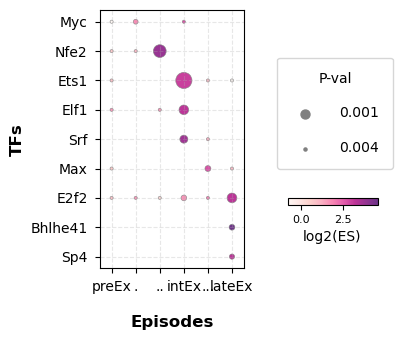

In [31]:
# TF order

#custom_tf_order_prdm1 = ['BPTF', 'SP1', 'BATF3', 'RBPJ', 'IKZF2']
#custom_tf_order_irf4 = ['MBD2', 'IKZF2', 'RBPJ', 'TCF12', 'BACH1', 'HMG20A']
#episode_labels=['ActB1/2', '.', '..', 'ActB3/4', '...', '....', '.....', 'lateGC']

# custom_tf_order_ets1_sig = ['Hdac2', 'Nfkb1', 'Ets1', 'Sin3a', 'Max']
#custom_tf_order_ikzf1_all = ['Ep300', 'E2f2', 'Klf6', 'Nfe2', 'Taf1', 'Nr4a2', 'Bhlhe40', 'Rad21', 'Klf2', 'Ctcf']
custom_tf_order_ets1_all = ['Myc', 'Nfe2', 'Ets1', 'Elf1', 'Srf', 'Max', 'E2f2', 'Bhlhe41', 'Sp4']
episode_labels=['preEx', '.', '..', 'intEx', '...', 'lateEx']

# custom_tf_order_z11_pb = ['CREB3L2', 'MEF2C', 'TFEC', 'TEAD2', 'IRF8', 'IRF9']
# custom_tf_order_z11_gc = ['IKZF3', 'USF2', 'IRF7', 'MEF2C', 'CDC5L', 'POU2F1']

# Use it in the plot
fig, plot_data, plotted_tfs = plot_tf_episodic_enrichment_dotplot(
    dfs=[df_ep1, df_ep2, df_ep3, df_ep4, df_ep5, df_ep6],
    episode_labels=episode_labels,
    figsize=(4.5, 3.5), #breadth by length
    p_value_threshold=0.004,
    min_significance_threshold=0.004,
    min_dot_size=10,    
    max_dot_size=200,   
    cmap_name="RdPu",
    tf_order=custom_tf_order_ets1_all,
    figure_title=None,
    log_scale=True,
    horizontal_layout=False
)
# save the plot
fig.savefig(os.path.join(config.OUTPUT_FOLDER, "ets1_ee.pdf"), dpi=300)

# Ext. Fig 3 - Chromatin level TF activity over pseudotime

In [24]:
class SmoothedCurvesChromatin:
    """
    A class to extract, process, and visualize Transcription Factor (TF) binding dynamics
    across genomic windows and pseudotime trajectories.
    """

    def __init__(self, tfs: List[str], base_path: str):
        """
        Initialize the chromatin accessibility data analyzer.

        Parameters:
        -----------
        tfs : list
            List of Transcription Factors to query.
        base_path : str
            Base path to the binding.tsv.gz files (e.g., 'path/to/tmp_dynamic').
        """
        self.tfs = tfs
        self.base_path = base_path
        
        # Data containers
        self.raw_scores: Dict[str, List[float]] = {}
        self.raw_counts: Dict[str, List[float]] = {}
        self.window_pseudotimes: Optional[np.ndarray] = None
        
        # Trajectory specific data
        self.pb_indices: Optional[List[int]] = None
        self.gc_indices: Optional[List[int]] = None
        self.pb_pseudotime: Optional[np.ndarray] = None
        self.gc_pseudotime: Optional[np.ndarray] = None
        
        # Processed series
        self.series_pb: Dict[str, np.ndarray] = {}
        self.series_gc: Dict[str, np.ndarray] = {}

    @staticmethod
    def _process_single_window(i: int, tfs: List[str], base_path: str) -> Tuple[int, Dict, Dict]:
        """
        Static worker method for multiprocessing. 
        Must be static to be pickleable by multiprocessing.Pool.
        """
        try:
            # Read the binding file
            file_path = f'{base_path}/Subset{i}/binding.tsv.gz'
            df = pd.read_csv(file_path, sep='\t', compression='gzip')
            
            # Efficient string parsing
            if 'loc' in df.columns:
                df[['chr', 'start', 'end']] = df['loc'].str.split(':', expand=True)
            
            window_scores = {}
            window_counts = {}
            
            # Group once to avoid repeated filtering of TFs
            grouped = df.groupby('TF')
            
            for tf in tfs:
                if tf in grouped.groups:
                    tf_df = grouped.get_group(tf)
                    # Mean score across chromosomes
                    window_scores[tf] = tf_df.groupby('chr').agg({'score': 'mean'}).mean().values[0]
                    # Count OCRs across chromosomes
                    window_counts[tf] = tf_df.groupby('chr').agg({'score': 'count'}).mean().values[0]
                else:
                    window_scores[tf] = float('nan')
                    window_counts[tf] = 0
            
            return (i, window_scores, window_counts)
        
        except Exception as e:
            # Silent fail for individual windows to keep process alive, but return safe defaults
            return (i, {tf: float('nan') for tf in tfs}, {tf: 0 for tf in tfs})

    @staticmethod
    def _to_float(v):
        if hasattr(v, "values"): # Handle Series/Array
            arr = v.values
            if len(arr) == 0: return np.nan
            return arr[0]
        return float(v)

    @staticmethod
    def _smooth(series, sigma):
        return gaussian_filter1d(series, sigma=sigma)

    # ------------------------------------------------------------------
    # Data Extraction Methods
    # ------------------------------------------------------------------

    def extract_data(self, n_windows: int = 194, n_processes: int = None):
        """
        Multiprocess the extraction of TF binding data across all windows.
        Populates self.raw_scores and self.raw_counts.
        """
        # Initialize result dictionaries
        self.raw_scores = {tf: [None] * n_windows for tf in self.tfs}
        self.raw_counts = {tf: [None] * n_windows for tf in self.tfs}
        
        if n_processes is None:
            n_processes = max(1, cpu_count() - 1)
        
        print(f"Processing {n_windows} windows using {n_processes} processes...")
        
        # Prepare arguments for the static worker
        process_func = partial(
            SmoothedCurvesChromatin._process_single_window, 
            tfs=self.tfs, 
            base_path=self.base_path
        )
        
        with Pool(processes=n_processes) as pool:
            results = list(tqdm(
                pool.imap(process_func, range(1, n_windows + 1)),
                total=n_windows,
                desc="Extracting Binding Data"
            ))
        
        # Collect results
        for window_idx, w_scores, w_counts in results:
            # Adjust 1-based index to 0-based list index
            idx = window_idx - 1
            if 0 <= idx < n_windows:
                for tf in self.tfs:
                    self.raw_scores[tf][idx] = w_scores.get(tf, np.nan)
                    self.raw_counts[tf][idx] = w_counts.get(tf, 0)
        
        print("Extraction complete.")

    # ------------------------------------------------------------------
    # Trajectory & Processing Methods
    # ------------------------------------------------------------------

    def set_trajectory_info(self, 
                            pb_indices: List[int], 
                            gc_indices: List[int], 
                            window_pseudotimes: Union[List, np.ndarray]):
        """
        Register trajectory indices and pseudotime values.
        
        Parameters:
        -----------
        pb_indices : List[int]
            0-based indices of windows belonging to the PB trajectory.
        gc_indices : List[int]
            0-based indices of windows belonging to the GC trajectory.
        window_pseudotimes : array-like
            Pseudotime value for every window (index corresponds to window ID).
        """
        self.pb_indices = pb_indices
        self.gc_indices = gc_indices
        self.window_pseudotimes = np.array(window_pseudotimes)
        
        # Map indices to pseudotimes immediately
        self.pb_pseudotime = self.window_pseudotimes[self.pb_indices]
        self.gc_pseudotime = self.window_pseudotimes[self.gc_indices]

    def process_dynamics(self, metric: str = 'score', smooth_sigma: float = 2.0):
        """
        Process raw data into ordered, smoothed trajectories for PB and GC.
        
        Parameters:
        -----------
        metric : str, 'score' or 'count'
            Which data source to process.
        smooth_sigma : float
            Sigma for Gaussian smoothing.
        """
        if self.pb_indices is None or self.gc_indices is None:
            raise ValueError("Trajectories not set. Call set_trajectory_info() first.")

        source_data = self.raw_scores if metric == 'score' else self.raw_counts
        
        self.series_pb = {}
        self.series_gc = {}

        for tf in self.tfs:
            # Get raw values (ensure they are floats)
            vals = [self._to_float(v) for v in source_data.get(tf, [])]
            vals_arr = np.array(vals)

            # Order based on trajectory indices
            ordered_pb = vals_arr[self.pb_indices]
            ordered_gc = vals_arr[self.gc_indices]

            # Smooth
            self.series_pb[tf] = self._smooth(ordered_pb, sigma=smooth_sigma)
            self.series_gc[tf] = self._smooth(ordered_gc, sigma=smooth_sigma)

    # ------------------------------------------------------------------
    # Visualization Methods
    # ------------------------------------------------------------------

    def plot(self, 
             categories: Dict[str, Dict[str, str]], 
             y_label: str = "Binding Score",
             title: str = None,
             truncate_pb: bool = True) -> go.Figure:
        """
        Generate Plotly figure for the processed dynamics.

        Parameters:
        -----------
        categories : dict
            Structure: {"CategoryName": { "TF_Name": "ColorHex", ... }, ...}
            Example: {"Static": {"TF1": "red"}, "Episodic": {"TF2": "blue"}}
        y_label : str
            Label for Y-axis.
        truncate_pb : bool
            If True, cuts the PB line to match the max pseudotime of GC.
        """
        if not self.series_pb:
            raise ValueError("No processed data found. Call process_dynamics() first.")

        # Determine truncation mask
        mask_pb = np.ones(len(self.pb_pseudotime), dtype=bool)
        max_gc_time = np.nanmax(self.gc_pseudotime)
        
        if truncate_pb:
            mask_pb = self.pb_pseudotime <= max_gc_time

        fig = go.Figure()

        # Iterate through categories (e.g., Static, Episodic)
        for cat_name, tf_color_map in categories.items():
            first_in_cat = True
            
            for tf, color in tf_color_map.items():
                if tf not in self.series_pb:
                    print(f"Warning: {tf} not found in processed data.")
                    continue

                # Add GC Trace (Dashed)
                fig.add_trace(go.Scatter(
                    x=self.gc_pseudotime,
                    y=self.series_gc[tf],
                    mode='lines',
                    name=tf,
                    line=dict(dash='dash', color=color, width=2.5),
                    legendgroup=tf,
                    legendgrouptitle_text=cat_name if first_in_cat else None,
                    showlegend=True
                ))

                # Add PB Trace (Solid)
                fig.add_trace(go.Scatter(
                    x=self.pb_pseudotime[mask_pb],
                    y=self.series_pb[tf][mask_pb],
                    mode='lines',
                    name=tf,
                    line=dict(dash='solid', color=color, width=2.5),
                    legendgroup=tf,
                    showlegend=False
                ))
                
                first_in_cat = False

        # Layout styling

        fig.update_layout(
            title=dict(text=title, x=0.5),
            xaxis=dict(
                title='Pseudotime',
                showgrid=True,
                range=[0, max_gc_time if truncate_pb else None]
            ),
            yaxis=dict(title=y_label),
            legend=dict(
                orientation='v', x=1.02, y=0.5,
                tracegroupgap=25,
                title_text="<b>TF Categories</b><br>(Solid=PB, Dashed=GC)"
            ),
            margin=dict(t=100, r=250),
            plot_bgcolor="white",
            paper_bgcolor="white",
            font=dict(family="Arial, sans-serif")
        )

        return fig

In [5]:
# list static and episodic TFs
static_tfs = ['PRDM1',
    'IRF4',
    'CREB3L2',
    'PAX5',
    'BATF',
    'BACH2']
episodic_tfs = ['IKZF2',
    'RBPJ',
    'NFATC2']
    
all_tfs = list(set(static_tfs + episodic_tfs))
base_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic'


In [25]:
smooth_chromatin_object = SmoothedCurvesChromatin(
    tfs=all_tfs,
    base_path=base_path
)

In [26]:
# Get pseudotime values for all windows
aligner = AlignTimeScales(
    dictys_dynamic_object=dictys_dynamic_object,
    trajectory_range=(1, 2),  # any trajectory starting from 1
    num_points=100,
    dist=0.0005,
    sparsity=0.01
)
window_pseudotimes = aligner.pseudotime_of_windows()

In [27]:
smooth_chromatin_object.set_trajectory_info(
    pb_indices=[1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2],
    gc_indices=[1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3],
    window_pseudotimes=window_pseudotimes
)

In [28]:
smooth_chromatin_object.extract_data(n_windows=194, n_processes=None)

Processing 194 windows using 127 processes...


Extracting Binding Data: 100%|██████████| 194/194 [00:02<00:00, 66.64it/s]


Extraction complete.


In [34]:
categories = {
    "Static": {
        "PRDM1": "#54278F",    # Dark purple
        "IRF4": "#756BB1",     # Purple
        "CREB3L2": "#9E9AC8",  # Medium purple
        "PAX5": "#BCBDDC",     # Light purple
        "BATF": "#DADAEB",     # Lighter purple
        "BACH2": "#EFEDF5"     # Lightest purple
    },
    "Episodic": {
        "IKZF2": "#D94701",    # Dark orange
        "RBPJ": "#F16913",     # Orange
        "NFATC2": "#FD8D3C"    # Light orange
    }
}

In [35]:
smooth_chromatin_object.process_dynamics(metric='score', smooth_sigma=2.0)
fig = smooth_chromatin_object.plot(categories=categories, y_label="TF Binding score", title=None)

# Save the figure as svg
fig.write_image(os.path.join(config.OUTPUT_FOLDER, "binding_score_all_tfs_ext_fig_3.svg"), format='svg')
fig.show()


In [36]:
smooth_chromatin_object.process_dynamics(metric='count', smooth_sigma=2.0)
fig = smooth_chromatin_object.plot(categories=categories, y_label="TF OCR count", title=None)

# Save the figure as svg
fig.write_image(os.path.join(config.OUTPUT_FOLDER, "ocr_count_all_tfs_ext_fig_3.svg"), format='svg')
fig.show()